#Table of Contents
* [1. Fitting a local equilibrium model to foam scan data](#1.-Fitting-a-local-equilibrium-model-to-foam-scan-data)
	* [1.1 Load data](#1.1-Load-data)
	* [1.2 Experimental data](#1.2-Experimental-data)
	* [1.3 Assign values to the physical parameters](#1.3-Assign-values-to-the-physical-parameters)
	* [1.4 Fit a new liquid relperm](#1.4-Fit-a-new-liquid-relperm)
	* [1.5 Relative permeability curves](#1.5-Relative-permeability-curves)
	* [1.6 Visualize RelPerms](#1.6-Visualize-RelPerms)
	* [1.7 Define the foam model](#1.7-Define-the-foam-model)
* [2. Boeije-Rossen method](#2.-Boeije-Rossen-method)
	* [2.1 Compare the model vs measured saturations](#2.1-Compare-the-model-vs-measured-saturations)
* [3. Ma et al. model](#3.-Ma-et-al.-model)
* [4. Nonlinear least-square model](#4.-Nonlinear-least-square-model)
	* [4.1 Calculate the liquid saturation for data points](#4.1-Calculate-the-liquid-saturation-for-data-points)
	* [4.2 Calculate the experimental foam parameters](#4.2-Calculate-the-experimental-foam-parameters)
	* [4.3 Create and solve a JuMP model: three parameters](#4.3-Create-and-solve-a-JuMP-model:-three-parameters)
	* [4.4 Create and solve a JuMP model: five parameters](#4.4-Create-and-solve-a-JuMP-model:-five-parameters)
	* [4.5 Visualize the results](#4.5-Visualize-the-results)
* [5. A discontinuous model](#5.-A-discontinuous-model)


# 1. Fitting a liquid relperm to foam scan-CT data

The saturation data, obtained in my foam scan experiment in CT room, is used here to optimize the parameters of a Corey-type liquid relperm model.

In [1]:
using JuMP, Roots, PyPlot, Ipopt, DataFrames, NLopt, PyCall, Optim
@pyimport scipy.optimize as so
PyPlot.rc("font", family="sans")
#PyPlot.rc("figure", figsize=(5,4))

INFO: Recompiling stale cache file /home/ali/.julia/lib/v0.5/JuMP.ji for module JuMP.
INFO: Recompiling stale cache file /home/ali/.julia/lib/v0.5/Ipopt.ji for module Ipopt.


## 1.1 Load data

First, I read the data table using the `DataFrames` package.

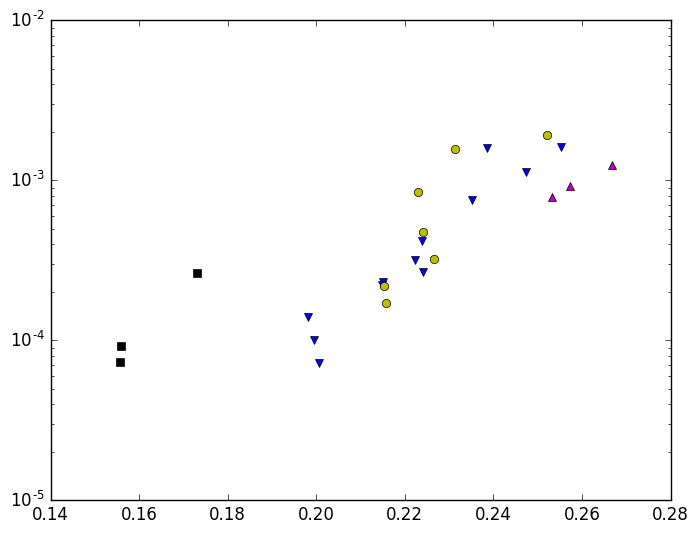

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff4bc9744d0>

In [2]:
data1 = readtable("krw_high_Amph.csv")
data2 = readtable("krw_low_AOS.csv")
data3 = readtable("krw_mid_AOS.csv")
data4 = readtable("krw_high_AOS.csv")
semilogy(data1[:sw], data1[:krw], "v")
semilogy(data2[:sw], data2[:krw], "^m")
semilogy(data3[:sw], data3[:krw], "oy")
semilogy(data4[:sw], data4[:krw], "sk")

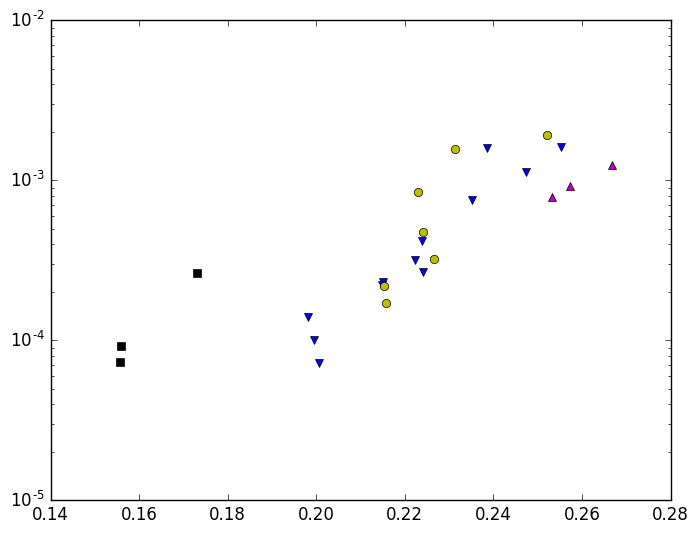

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff4bc6e5cd0>

In [3]:
sgr=0.03
sw(x)=x[1]*((sw-x[3])/(1-x[3]-sgr))^x[2]
rel_perm_liq=[0.713 2.460 0.25; 
    0.713 2.460 0.200;
    0.713 2.460 0.184;
    0.713 2.460 0.063;
    0.713 2.460 0.181]
sw_plot=collect(linspace(0.05,0.30,50))
semilogy(data1[:sw], data1[:krw], "v")
semilogy(data2[:sw], data2[:krw], "^m")
semilogy(data3[:sw], data3[:krw], "oy")
semilogy(data4[:sw], data4[:krw], "sk")

## 1.4 Fit a new liquid relperm

Here, I fit a new liquid relperm to the low quality data points.

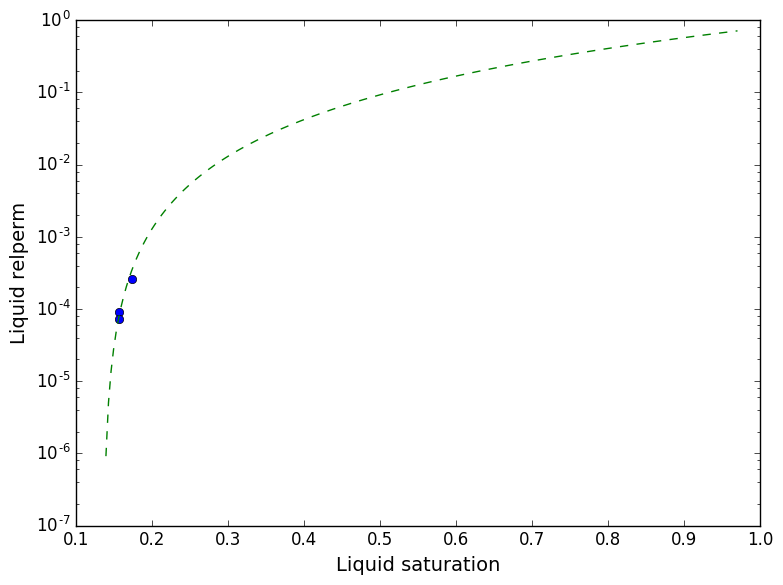

4-element Array{Float64,1}:
 0.713   
 2.46    
 0.135429
 0.03    

In [7]:
# I only use the less-scattered data in the low quality region
#filter for measured saturation
#krw_exp= float([data1[:krw]; data2[:krw]; data3[:krw]; data4[:krw]])
#sw_low_ct=float([data1[:sw]; data2[:sw]; data3[:sw]; data4[:sw]])
krw_exp= float(data4[:krw])
sw_low_ct=float(data4[:sw])
n_low=length(sw_low_ct)
semilogy(sw_low_ct, krw_exp, "o")
m1 = Model(solver=IpoptSolver(print_level=1))
#m = Model()
# define the variables of the foam model
#@defVar(m1, 2.5<=nw_fit<=4.0)
@defVar(m1, nw_fit==2.46)
#@defVar(m1, 0.01<=krw0_fit<=1.0)
@defVar(m1, krw0_fit==0.713)
@defVar(m1, 0.02<=swc_fit<=0.25)
#@defVar(m1, 0.001<=sgr_fit<=0.1)
@defVar(m1, sgr_fit==0.03)
@setNLObjective(m1, Min, sum{(log(krw_exp[i])-log(krw0_fit)-nw_fit*log((sw_low_ct[i]-swc_fit)/(1.0-swc_fit-sgr_fit)))^2, i=1:n_low})
#@setNLObjective(m1, Min, sum{(krw_exp[i]-krw0_fit*((sw_low_ct[i]-swc_fit)/(1.0-swc_fit-sgr_fit))^nw_fit)^2, i=1:n_low})
solve(m1)
# get the result
liq_relperm=[getValue(krw0_fit), getValue(nw_fit), getValue(swc_fit), getValue(sgr_fit)]
sw1=[linspace(liq_relperm[3], 0.3, 50); linspace(0.3,1.0-liq_relperm[4], 50)]
semilogy(sw1, liq_relperm[1]*((sw1-liq_relperm[3])/(1-liq_relperm[4]-liq_relperm[3])).^liq_relperm[2], "--")
xlabel("Liquid saturation", fontsize=14)
ylabel("Liquid relperm", fontsize=14)
tight_layout()
savefig("liqrelperm.png")
liq_relperm

## 1.5 Relative permeability curves

In [5]:
# Relperm data
swc = liq_relperm[3]
sgr = liq_relperm[4]
krg0 = 0.94
ng = 1.8
krw0 = liq_relperm[1]
nw = liq_relperm[2]
sws(sw::Real)=((sw>swc)*(sw<1-sgr)*(sw-swc)/(1-sgr-swc)+(sw>=1-sgr)*1.0)
sws(sw::Array{Float64})=((sw.>swc).*(sw.<1-sgr).*(sw-swc)/(1-sgr-swc)+
(sw.>=1-sgr).*ones(size(sw)))
kr(sw)=((sw.>=swc).*krg0.*(1-sws(sw)).^ng+(sw.<swc).*(1+(krg0-1)/swc*sw))
krw(sw)=((sw.<=1-sgr).*krw0.*sws(sw).^nw+(sw.>1-sgr).*
(-(1-krw0)/sgr.*(1.0-sw)+1.0));

## 1.6 Visualize RelPerms

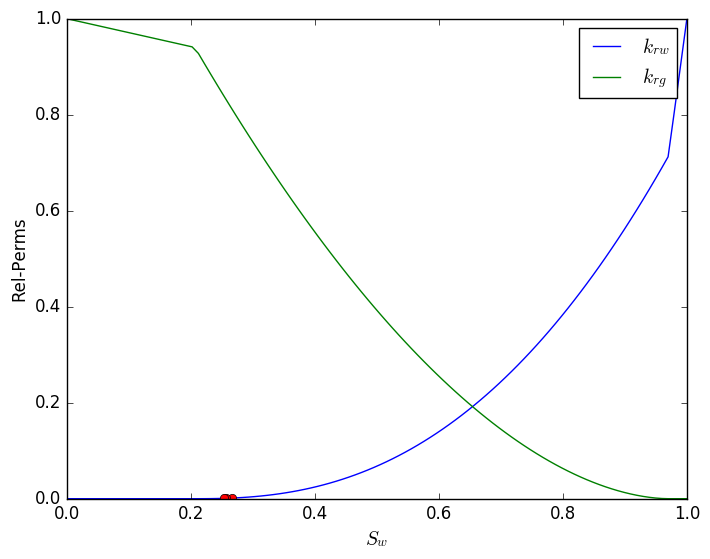

In [6]:
sw_plot = collect(linspace(0.0,1.0, 100))
plot(sw_plot, krw(sw_plot), sw_plot, kr(sw_plot))
plot(sw_low_ct, krw_exp, "o")
xlabel(L"S_w", fontsize=14)
ylabel("Rel-Perms")
legend([L"k_{rw}", L"k_{rg}"], fontsize=14);